In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import os
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import LearningRateScheduler

/opt/homebrew/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Loading data

In [2]:
# Download data here : https://downloads.viscoda.com/research/roadsaw/log.txt

# RoadSaW with 12 classes
# train_path = '/Users/kevinsam/Desktop/Unif/Master/ThesisWheelchair/DATA/RoadSaW/RoadSaW-075_s/train'
# validation_path = train_path = '/Users/kevinsam/Desktop/Unif/Master/ThesisWheelchair/DATA/RoadSaW/RoadSaW-075_s/validation'
# test_path = '/Users/kevinsam/Desktop/Unif/Master/ThesisWheelchair/DATA/RoadSaW/RoadSaW-075_s/test'

#RoadSaW with 6 classes
train_path = '/Users/kevinsam/Desktop/Unif/Master/ThesisWheelchair/DATA/RoadSaW/RoadSaW6-075_l/train'
validation_path = train_path = '/Users/kevinsam/Desktop/Unif/Master/ThesisWheelchair/DATA/RoadSaW/RoadSaW6-075_l/validation'
test_path = '/Users/kevinsam/Desktop/Unif/Master/ThesisWheelchair/DATA/RoadSaW/RoadSaW6-075_l/test'

# Assuming you have a directory structure with subdirectories for each class
class_names = sorted(os.listdir(train_path))

# Set image size and number of classes
img_size = (224, 224)
num_classes = len(class_names)

#number of epochs
num_epochs = 10

#initial learning rates of two phases
init_lr_1 = 0.001
init_lr_2 = 1e-5

In [3]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to the range [0, 1]
    # horizontal_flip=True,
    # zoom_range=[0.9, 1.1],  # Scaling [90%, 110%]
    # width_shift_range=[-0.1, 0.1],  # Shifting horizontally [-10%, 10%]
    # height_shift_range=[-0.1, 0.1],  # Shifting vertically [-10%, 10%]
    # shear_range=0.1,  # Shearing [-10%, 10%]
)

# Assuming you have a directory structure with train and validation sets
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle = True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle = True
)

Found 4092 images belonging to 6 classes.
Found 4092 images belonging to 6 classes.


In [4]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_size[0], img_size[1], 3), include_top=False, weights='imagenet')

In [5]:
#Freeze the layers of the base network
for layer in base_model.layers:
    layer.trainable = False

In [6]:
# Create your own model on top of MobileNetV2
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
 
opt1 = tfa.optimizers.RectifiedAdam(learning_rate=init_lr_1)

model.compile(optimizer=opt1, loss='categorical_crossentropy', metrics=['accuracy'])

# Define a function to compute the learning rate schedule
def lr_schedule(epoch, initial_lr):
    return initial_lr * 0.9 ** epoch

lr_callback1 = LearningRateScheduler(lambda epoch: lr_schedule(epoch, init_lr_1), verbose=1)

In [7]:
#Phase 1 
hist1 = model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator)

Epoch 1/10
128/128 [==============================] - 196s 2s/step - loss: 1.2514 - accuracy: 0.5543 - val_loss: 0.3801 - val_accuracy: 0.9348
Epoch 2/10
128/128 [==============================] - 197s 2s/step - loss: 0.3408 - accuracy: 0.9052 - val_loss: 0.1762 - val_accuracy: 0.9597
Epoch 3/10
128/128 [==============================] - 196s 2s/step - loss: 0.2133 - accuracy: 0.9413 - val_loss: 0.1280 - val_accuracy: 0.9685
Epoch 4/10
128/128 [==============================] - 198s 2s/step - loss: 0.1610 - accuracy: 0.9550 - val_loss: 0.1028 - val_accuracy: 0.9729
Epoch 5/10
128/128 [==============================] - 197s 2s/step - loss: 0.1418 - accuracy: 0.9604 - val_loss: 0.0965 - val_accuracy: 0.9729
Epoch 6/10
128/128 [==============================] - 196s 2s/step - loss: 0.1236 - accuracy: 0.9638 - val_loss: 0.0854 - val_accuracy: 0.9729
Epoch 7/10
128/128 [==============================] - 196s 2s/step - loss: 0.1007 - accuracy: 0.9692 - val_loss: 0.0753 - val_accuracy: 0.9746

In [8]:
# # Unfreeze the convolutional base for fine-tuning
# for layer in base_model.layers:
#     layer.trainable = True

# opt2 = tfa.optimizers.RectifiedAdam(learning_rate=init_lr_2-5)
# # Lower the learning rate for fine-tuning
# model.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['accuracy'])

# lr_callback1 = LearningRateScheduler(lambda epoch: lr_schedule(epoch, init_lr_2), verbose=1)

In [9]:
#Phase 2 
# hist2 = model.fit(train_generator, epochs=num_epochs, callbacks=[lr_callback1],validation_data=validation_generator)

In [10]:
#Save the model 
model.save(os.path.join('models','RW6lclassifierV1.keras'))

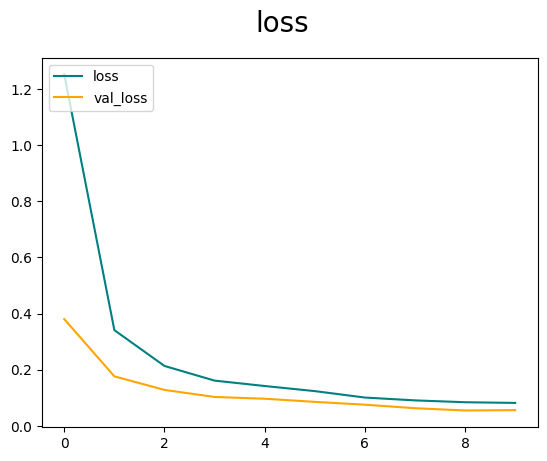

In [11]:
from matplotlib import pyplot as plt

fig = plt.figure()
plt.plot(hist1.history['loss'],color='teal',label='loss')
plt.plot(hist1.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

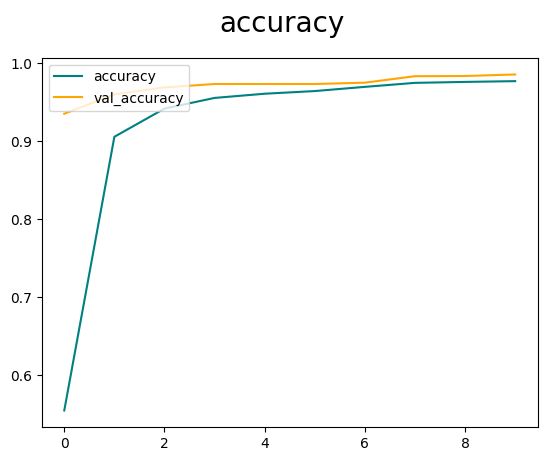

In [12]:
fig = plt.figure()
plt.plot(hist1.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist1.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle = True
)

Found 1752 images belonging to 6 classes.


In [15]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.models import load_model

# Assuming you have already trained and saved your model
model = load_model('models/RW6lclassifierV1.keras')

# Use the test_generator to generate predictions
y_pred = model.predict(test_generator)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get true labels from the test_generator
y_true = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_labels)
print(f'Accuracy: {accuracy}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)
print(f'Confusion Matrix:\n{conf_matrix}')

# Calculate precision, recall, and F1-score
class_report = classification_report(y_true, y_pred_labels)
print(f'Classification Report:\n{class_report}')


55/55 [==============================] - 41s 731ms/step
Accuracy: 0.1695205479452055
Confusion Matrix:
[[50 23 53 38 60 68]
 [58 19 51 40 73 51]
 [35 31 59 38 75 54]
 [45 28 62 42 58 57]
 [57 15 47 32 73 68]
 [49 18 58 40 73 54]]
Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.17      0.17       292
           1       0.14      0.07      0.09       292
           2       0.18      0.20      0.19       292
           3       0.18      0.14      0.16       292
           4       0.18      0.25      0.21       292
           5       0.15      0.18      0.17       292

    accuracy                           0.17      1752
   macro avg       0.17      0.17      0.16      1752
weighted avg       0.17      0.17      0.16      1752



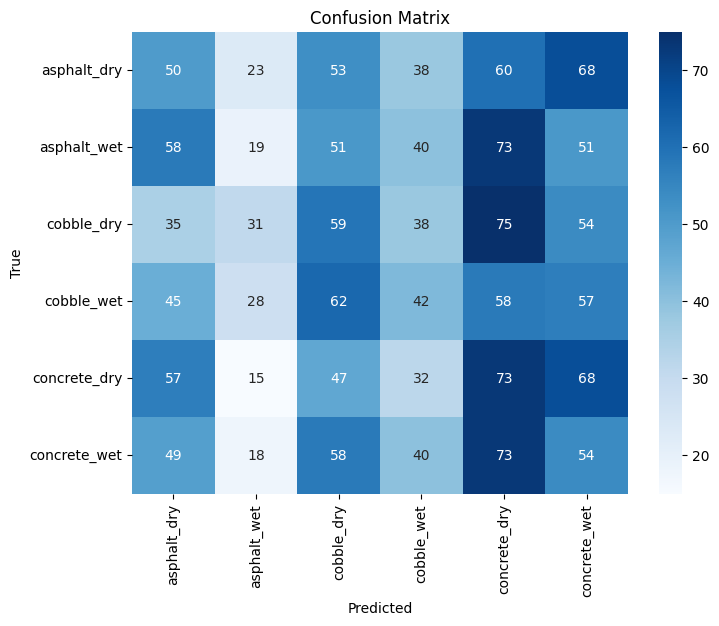

In [16]:
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

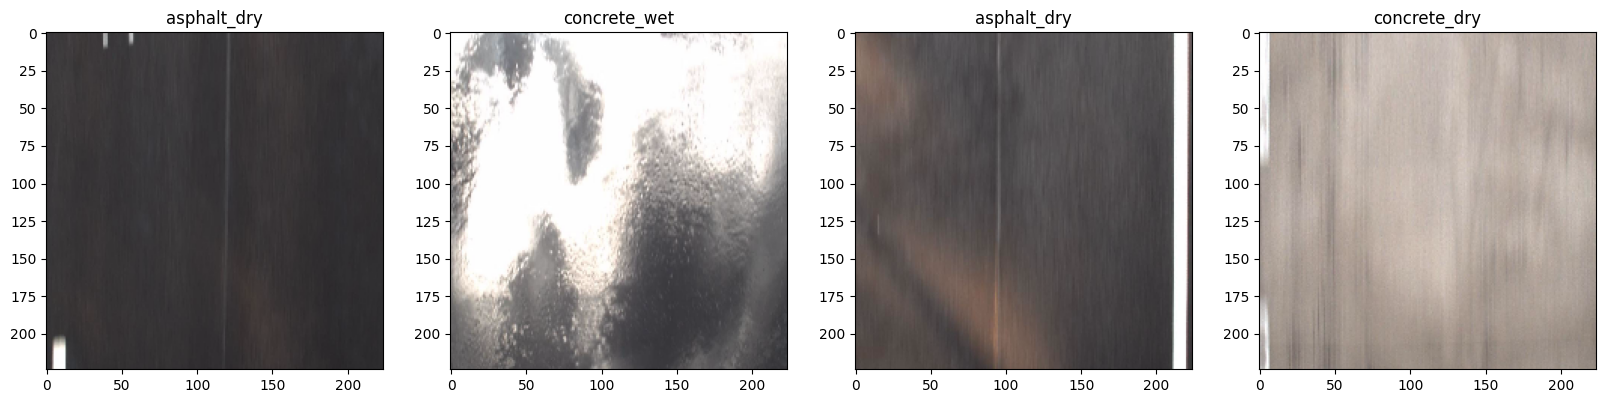

In [17]:
batch = test_generator.next()
images = batch[0]
labels = batch[1]

fig, ax = plt.subplots(ncols=4,figsize =(20,20))

for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(class_names[batch[1][idx].argmax()])

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes= np.unique(train_generator.classes),y= train_generator.classes)

class_weights

array([1., 1., 1., 1., 1., 1.])

In [22]:
from tensorflow.keras.metrics import Precision,Recall,Accuracy

pre = Precision()
re = Recall()
acc = Accuracy()

for i in range(len(test_generator)):
    x_test_batch, y_test_batch = next(test_generator)
    yhat = model.predict(x_test_batch)
    pre.update_state(y_test_batch,yhat)
    re.update_state(y_test_batch,yhat)
    acc.update_state(y_test_batch,yhat)

    print(f"P: {np.argmax(yhat,axis=1)}")
    print(f"T: {np.argmax(y_test_batch,axis=1)}")

print(f"Precision {pre.result().numpy()} , Recall {re.result().numpy()} , Accuracy {acc.result().numpy()}")

1/1 [==============================] - 0s 209ms/step
P: [5 4 4 0 0 5 4 2 0 2 4 3 0 3 0 0 0 2 4 0 0 5 5 5 0 2 4 4 2 0 0 4]
T: [5 4 4 0 0 1 0 2 0 2 4 3 0 3 1 1 1 2 4 1 0 5 5 5 0 2 4 4 2 1 0 4]
1/1 [==============================] - 0s 204ms/step
P: [1 4 0 2 2 5 2 0 0 1 5 1 2 2 4 2 5 0 4 3 5 4 3 4 1 5 2 1 2 5 5 5]
T: [1 4 0 2 2 5 3 0 1 1 5 1 3 3 4 2 5 0 0 3 5 0 3 0 3 5 2 3 2 1 1 5]
1/1 [==============================] - 0s 178ms/step
P: [5 4 3 3 5 5 3 2 5 3 0 2 5 5 3 5 5 1 2 5 3 5 4 4 5 1 1 4 4 4 4 3]
T: [5 0 2 3 5 1 3 2 5 3 1 3 5 5 3 5 5 3 2 5 3 5 4 1 1 1 0 4 4 4 4 3]
1/1 [==============================] - 0s 182ms/step
P: [4 1 2 5 5 4 4 3 4 2 0 3 0 4 3 5 4 0 0 3 2 3 2 3 0 1 0 2 4 3 4 4]
T: [4 3 2 5 5 0 1 3 0 2 0 3 0 4 3 5 4 1 1 3 2 3 2 3 0 1 0 2 1 3 4 0]
1/1 [==============================] - 0s 183ms/step
P: [4 5 2 3 5 4 4 0 4 5 0 2 5 0 2 3 5 2 5 4 4 4 2 4 0 0 0 4 4 0 5 1]
T: [4 5 2 3 5 1 0 0 1 5 0 2 5 0 2 3 5 2 1 4 1 4 2 4 0 0 0 4 4 1 5 1]
1/1 [==============================] - 0s 200